# Producing multiple peaked synthetic profiles
## Background
It is standard practice in flood modelling to use design rainfall profiles generated by FEH/ReFH2. We are interested in examining whether distributing rainfall over time in multiple peaks, rather than just one, will result in a different flooding outcome. 

## Constructing synthetic multiple peaked events
The FEH single-peak profiles are always produced with a single peak which can be characterised by:
1) The total corresponding rainfall volume $V$.  
2) The duration $d$ (start to end).  
3) The shape of the peak, defined here: https://refhdocs.hydrosolutions.co.uk/Design-DDF-Rainfall-Hyetographs/Design-Storm-Profiles/  
 
To construct multiple peaked events, we need to consider:  
 1) The rainfall volume$ V_1,...V_N$ for each peak. Suggestion: use $V/N$, so we have the same total rainfall.  
 2) The shape of each peak. Suggestion: use the same shape, but different peak rainfall height so it gives the desired volume  given a start-to-end duration for the peak.  
 3) The start-to-end duration of each peak. This is a parameter we can play with, but probably we will mainly look at short durations.  
 4) The spacing between peaks. Here, the question is what a "fair" spacing for comparison so that the overall "event duration" is the same, and this is probably a bit subjective. We could also consider this as another parameter to play with.  
 


In [4]:
from datetime import datetime, timedelta
import pandas as pd
from dateutil.relativedelta import relativedelta
import sys
import matplotlib.patches as mpatches
from matplotlib import dates as mdates
import re
sys.path.insert(1, '../')
from Functions import *

### Define the different methods 

In [5]:
percent_increases =['0', '05','10','20']
durations = ['1h', '3h', '6h']

### Create a single peaked profile with 10% extra volume

In [16]:
method = 'sp'
duration = '6h'
N_subpeaks = 1
# Set default peak shape and location of the peak (always in the middle)
default_peak_shape='refh2-summer'
peak_before_frac = 0.5
# FInd total event duration and subpeak duration (needed even tho this is a single peak event)
total_duration_minutes= int(duration[0]) * 60
subpeak_duration_minutes=total_duration_minutes/6

for percent_increase in percent_increases:

    # Find the multiplier and use to multiply the total event accumulation
    multiplier = np.float64('1.{}'.format(percent_increase))
    total_mm_accum=  59.98 * multiplier

    # Create datetimes to go with values
    start = datetime(2022,8,1,0,0,0)
    end = start + relativedelta(hours=int(duration[0]))
    end = end - timedelta(minutes=1) 
    seconds = (end - start).total_seconds() + 60
    step = timedelta(minutes=1)
    datetimes = []
    for i in range(0, int(seconds), int(step.total_seconds())):
        datetimes.append(start + timedelta(seconds=i))       

    # Find accumulation and rate
    accum, rate = calc_rainfall_curves(method,total_mm_accum,total_duration_minutes,N_subpeaks,subpeak_duration_minutes,peak_before_frac)
    # Create as dataframe
    accum_df = pd.DataFrame({'Dates': datetimes,  'Rate (mm/hr)': rate, 'Rate (mm/min)': rate/60})
    # Keep only columns needed for feeding to ReFH2
    accum_df = accum_df[['Dates','Rate (mm/min)']]

    # Write to csv
    accum_df.to_csv("{}r_100yrRP/PreLossRemoval/{}_{}_+{}%volume.csv".format(duration,duration, method, percent_increase),
                   header = False, index = False)
    if percent_increase == '0':
        all_accums = accum_df.copy()
        all_accums.rename(columns ={'Rate (mm/min)':percent_increase}, inplace = True)
    else:
        all_accums[percent_increase] = accum_df['Rate (mm/min)']
    
    print("Percent increase in volume:" + percent_increase+ '%' + '. New total volume: ' + str(total_mm_accum))
    print("Maximum rate (mm/min): " + str(round(all_accums[percent_increase].max(),1)))

Percent increase in volume:0%. New total volume: 59.98
Maximum rate (mm/min): 1.1
Percent increase in volume:05%. New total volume: 62.979
Maximum rate (mm/min): 1.2
Percent increase in volume:10%. New total volume: 65.97800000000001
Maximum rate (mm/min): 1.2
Percent increase in volume:20%. New total volume: 71.976
Maximum rate (mm/min): 1.3


## Pre and post loss removal: plot single peak profiles with scaled volumes

In [8]:
colors =['#82a2cf', '#566cb8', '#2b36a2', '#00008b']
percent_increases

['0', '05', '10', '20']

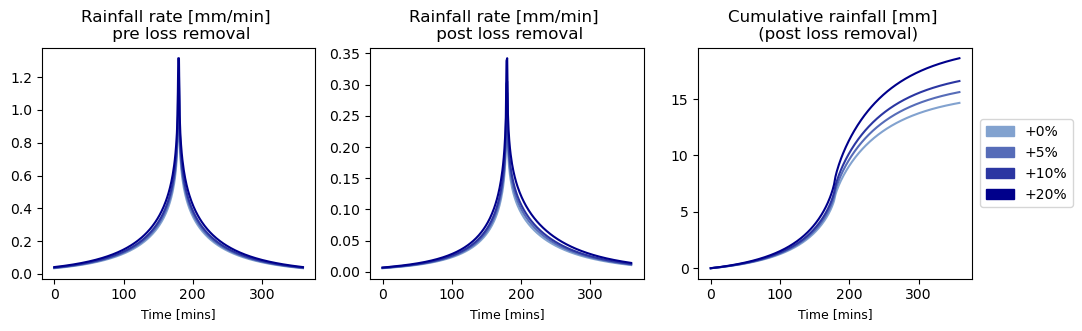

In [37]:
fig,axs=plt.subplots(1,3, figsize=(12,3))
for col_num, percent_increase in enumerate(percent_increases):
    pre_loss_removal = pd.read_csv("6hr_100yrRP/PreLossRemoval/6h_sp_+{}%volume.csv".format(percent_increase), names =['Time', 'Rain'])
    pre_loss_removal['Time'] =  np.array(range(total_duration_minutes)) 
    # Read in post loss removal rainfall rate
    post_loss_removal = pd.read_csv("6hr_100yrRP/PostLossRemoval/6h_sp_+{}_urban.csv".format(percent_increase))
    # Filter to only include those within the first 6 hours
    post_loss_removal = post_loss_removal[:360]
    # Find cumulative rainfall rate
    post_loss_removal['cumulative_rainfall_this_min'] = post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].cumsum()
    # Convert date to datetime
    post_loss_removal['Time'] =  np.array(range(total_duration_minutes))     
    # PLot
    axs[0].plot(pre_loss_removal['Time'], pre_loss_removal['Rain'], color = colors[col_num])
    axs[0].set_xlabel('Time [mins]', fontsize = 9)
    axs[0].set_title('Rainfall rate [mm/min] \n pre loss removal')
    
    axs[1].plot(post_loss_removal['Time'], post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'],
               colors[col_num])
    axs[1].set_xlabel('Time [mins]', fontsize = 9)
    axs[1].set_title('Rainfall rate [mm/min] \n post loss removal')
    
    axs[2].plot(post_loss_removal['Time'], post_loss_removal['cumulative_rainfall_this_min'],
               colors[col_num])
    axs[2].set_xlabel('Time [mins]', fontsize = 9)
    axs[2].set_title('Cumulative rainfall [mm] \n (post loss removal)')
    
colors_leg = ['#82a2cf', '#566cb8', '#2b36a2', '#00008b']
texts = ['+0%','+5%','+10%', '+20%'] 
patches = [ mpatches.Patch(color=colors_leg[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.2, 0.5), loc='center', ncol=1, prop={'size': 10} );        